# GAN DATA GENERATION

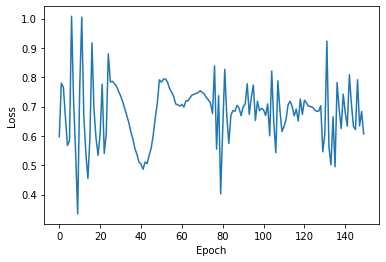

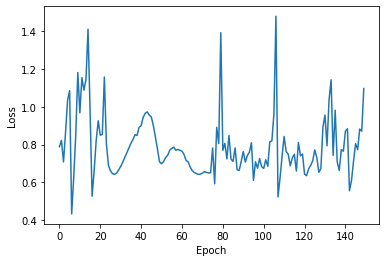

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import copy
import matplotlib.pyplot as plt


data=pd.read_excel(r"RealSample_INL_Phyllis_9April21.xlsx",'All Real Samples')
data["SampleType"] = "Real Samples"

data.query('Cellulose >= 0 & Hemicellulose >= 0 & (Cellulose + Hemicellulose <= 1)')

data_c=data.iloc[:,0:1]
data_hc=data.iloc[:,1:2]

torch.manual_seed(100)

def largest_prime_factor(n):
    i = 2
    while i * i <= n:
        if n % i:
            i += 1
        else:
            n //= i
    return n

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(2,256),
        nn.ReLU(),
#         nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.ReLU(),
#         nn.Dropout(0.3),
        nn.Linear(128, 64),
        nn.ReLU(),
#         nn.Dropout(0.3),
        nn.Linear(64, 1),
        nn.Sigmoid()
    )  

  def forward(self, x):
    output = self.model(x)
    return output

class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(2, 16),
        nn.ReLU(),
        nn.Linear(16, 32),
        nn.ReLU(),
        nn.Linear(32, 2)

    )

  def forward(self, x):
    output = self.model(x)
    return output

discriminator_loss = []
generator_loss = []
discriminator = Discriminator()
generator = Generator()

def data_gen_controller(input_data):
  train_data = torch.zeros((len(input_data), 2)) #init a tensor of zeros
  train_data[:, 0] = torch.tensor(input_data['Cellulose'].values)
  train_data[:, 1] = torch.tensor(input_data['Hemicellulose'].values)
  train_labels = torch.zeros(len(input_data)) #init tensor of training labels
  train_set = [
    (train_data[i], train_labels[i]) for i in range(len(input_data))
  ]
  batch_size = largest_prime_factor(len(input_data))
  train_loader = torch.utils.data.DataLoader(
      train_set, batch_size = batch_size, shuffle=True
  )
  lr = 0.001
  num_epochs = 25
  loss_function  = nn.BCELoss()
  optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
  optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

  for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
      #data for training the discriminator
      real_samples_labels = torch.ones((batch_size, 1))
      latent_space_samples = torch.randn((batch_size, 2))
      generated_samples = generator(latent_space_samples)
      generated_samples_labels = torch.zeros((batch_size, 1))
      all_samples = torch.cat((real_samples, generated_samples))
      all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

      #training the discriminator
      discriminator.zero_grad()
      output_discriminator = discriminator(all_samples)
      loss_discriminator = loss_function(output_discriminator, all_samples_labels)
      loss_discriminator.backward()
      optimizer_discriminator.step()

      #data for training the generator
      latent_space_samples = torch.randn((batch_size, 2))

      #training the generator
      generator.zero_grad()
      generated_samples = generator(latent_space_samples)
      output_discriminator_generated = discriminator(generated_samples)
      loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
      loss_generator.backward()
      optimizer_generator.step()
    discriminator_loss.append(loss_discriminator)
    generator_loss.append(loss_generator)


output_df = pd.DataFrame(data, columns=["Cellulose", "Hemicellulose", "SampleType"])

while len(output_df) < 3000:
  data_gen_controller(output_df)
  latent_space_samples = torch.randn(500, 2)
  generated_samples = generator(latent_space_samples)
  generated_samples = generated_samples.detach()
  generated_samples_df = generated_samples.numpy()
  generated_samples_df = pd.DataFrame(generated_samples_df)
  generated_samples_df.columns = ["Cellulose", "Hemicellulose"]
  generated_samples_df["SampleType"] = "Generated Samples"
  generated_samples_df.append(output_df)
  output_df = output_df.append(generated_samples_df)
  output_df = output_df.query('Cellulose >= 0 & Hemicellulose >= 0 & (Cellulose + Hemicellulose <= 1)')

output_df.query('SampleType == "Generated Samples"')

plt.plot(list(range(len(discriminator_loss))), discriminator_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(list(range(len(generator_loss))), generator_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()



### **KDE DATA GENERATION**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

from scipy.stats import norm, gaussian_kde
%matplotlib inline

df_in=pd.read_excel('RealSample_INL_Phyllis_9April21.xlsx', 'All Real Samples') #reading the INL data

data_input1=df_in.iloc[0:14,0:6]
data_cellulose=df_in.iloc[:,0:1]
data_hemi=df_in.iloc[:,1:2]
data_values=df_in.iloc[:,0:2]

X=data_values
first_set = pd.DataFrame(X, columns=['Cellulose','Hemicellulose'])
output_df = pd.DataFrame(X, columns=['Cellulose','Hemicellulose'])
output_df['SampleType'] = "Real Samples"

def kde_value_generator(x):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(x)
    predicted_vals=pd.DataFrame(kde.sample(1000))
    predicted_vals.columns =['Cellulose','Hemicellulose']
    cellulose_gt_zero =  predicted_vals['Cellulose'] > 0
    
    hemicellulose_df = predicted_vals.query('Cellulose > 0 & Hemicellulose > 0 & (Cellulose + Hemicellulose <= 1)')
    
    for index, rows in hemicellulose_df.iterrows():
        first_set.loc[len(first_set.index)] = [rows['Cellulose'], rows['Hemicellulose']]
        output_df.loc[len(output_df.index)] = [rows['Cellulose'], rows['Hemicellulose'], "Generated Samples"]

while len(first_set) < 3000:
    kde_value_generator(X)
    X = first_set

output_df.query("Cellulose + Hemicellulose < 1")

,Cellulose,Hemicellulose,SampleType
0,0.431934,0.388946,Real Samples
1,0.526316,0.242105,Real Samples
2,0.513514,0.189189,Real Samples
3,0.421158,0.279441,Real Samples
4,0.513514,0.243243,Real Samples
...,...,...,...
3738,0.548103,0.226832,Generated Samples
3739,0.566021,0.278709,Generated Samples
3740,0.109614,0.278324,Generated Samples
3741,0.257098,0.290636,Generated Samples
